# DNMT3A Subgroup Relative Error Plots for Convergence
***
### Runs the DNMT3A subgroup simulation. Then it calculates the apoptosis, proliferation, differentiation, and network scores to create the relative error plots for each example 

### Importing the BMatrix and BooleanNetwork code

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

# import booleanNetwork module from ./src
import sys
sys.path.append('./src')
import booleanNetwork as bn
import BMatrix 

### Creating the variables for the simulation + calculation

In [13]:
sim_equations_file = './input_files/dnmt3a_equations.txt' #does not have the equations at the end

equations = BMatrix.get_equations(sim_equations_file)
gene_dict = BMatrix.get_gene_dict(equations)
upstream_genes = BMatrix.get_upstream_genes(equations)

connectivity_matrix = BMatrix.get_connectivity_matrix(equations,upstream_genes,gene_dict)
connectivity_matrix = np.array(connectivity_matrix)
#print(connectivity_matrix)

truth_table = BMatrix.get_truth_table(equations, upstream_genes)
truth_table = np.array(truth_table)
#print(truth_table)

ngenes= len(equations)

x0 = np.random.randint(2, size=ngenes) #random inital state 
x0 = np.array(x0)
#print(x0)

calculating_file = './input_files/calculating_equations.txt'

cal_equations = BMatrix.get_equations(calculating_file) 
cal_upstream_genes = BMatrix.get_cal_upstream_genes(cal_equations)
cal_functions = BMatrix.get_cal_functions(cal_equations)

In [14]:
gene_dict

{'FLT3': 0,
 'AKT': 1,
 'CEBPA': 2,
 'DNMT3A': 3,
 'GSK3B': 4,
 'NPM1': 5,
 'ARF': 6,
 'HOXA9': 7,
 'FBXW7': 8,
 'ERK': 9,
 'CDKN2A': 10,
 'STAT5A': 11,
 'SOX4': 12,
 'CCND1': 13,
 'MEIS1': 14,
 'MYC': 15,
 'ETV6': 16,
 'TP53': 17,
 'BCL2': 18}

## Testing Fixed Point

In [15]:
network = bn.BooleanNetwork( ngenes , connectivity_matrix, truth_table, x0  ) # create a Boolean network object
network_traj = network.update (200) # simulation with noise

#wt = biolqm.perturbation(palma_lqm, "FLT3%0 DNMT3A%1 NPM1%1")


In [23]:
network_traj[-10:]

array([[0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0]],
      dtype=int8)

## Testing different amount of steps and noise with relative error

### Original (0.05 noise and 200,000 steps)

In [4]:
%%time

network = bn.BooleanNetwork( ngenes , connectivity_matrix, truth_table, x0  ) # create a Boolean network object
noise_level = 0.05 # noise
network_traj = network.update_noise ( noise_level  , 200000) # simulation with noise

CPU times: total: 6.52 s
Wall time: 6.52 s


In [5]:
%%time

cal_range = network_traj 
scores_dict, final_score = BMatrix. get_calculating_scores(network_traj, cal_functions, cal_upstream_genes, gene_dict,cal_range)

CPU times: total: 7.12 s
Wall time: 7.15 s


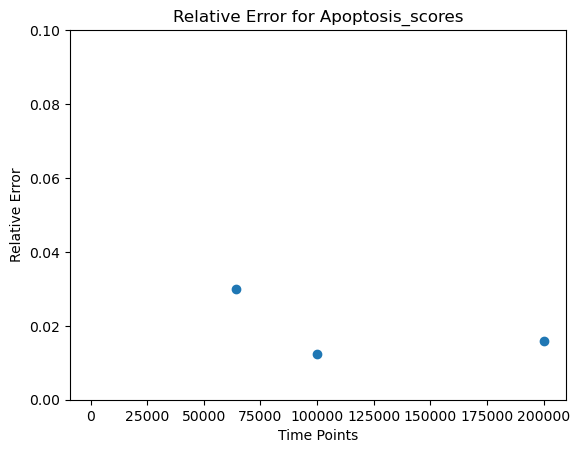

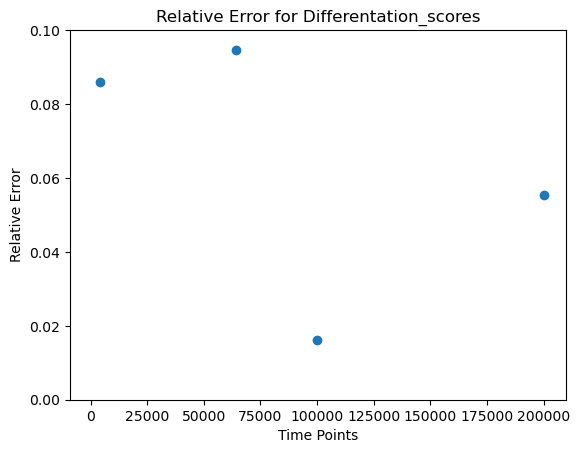

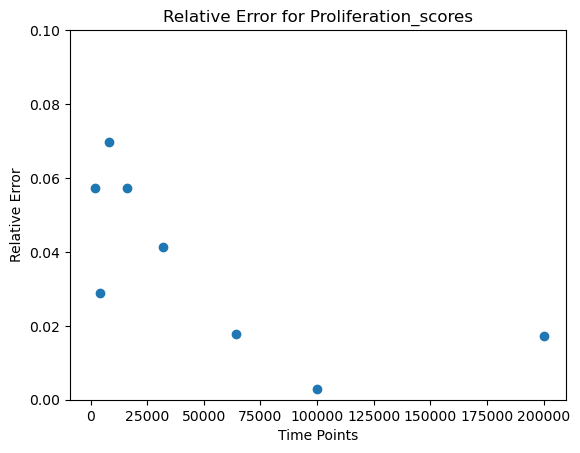

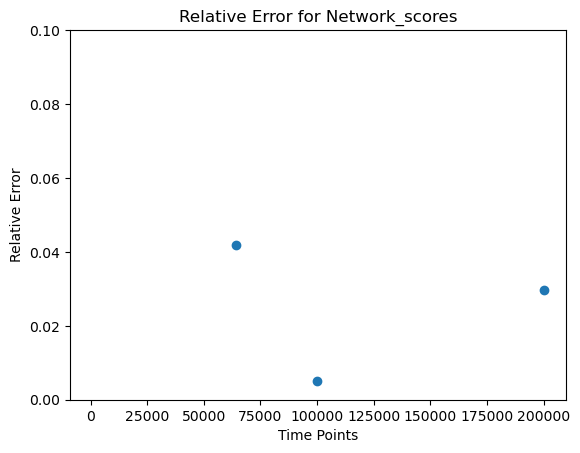

In [6]:
#getting the relative error points to see if the score converges
Apoptosis_scores = scores_dict['Apoptosis']
Differentiation_scores = scores_dict['Differentiation']
Proliferation_scores = scores_dict['Proliferation']
Network_scores = scores_dict['Network']

scores = [Apoptosis_scores, Differentiation_scores, Proliferation_scores, Network_scores]
time_points = [1000, 2000, 4000, 8000, 16000, 32000, 64000, 100000, 200000]

plot_title = {0:'Apoptosis_scores',
              1:'Differentation_scores',
              2: 'Proliferation_scores',
              3: 'Network_scores'}

#print(plot_title)
#print(time_points)

for i in range(len(scores)): #for apop, diff, prolif, or final
    values = [] 
    relative_error = [] #reset the values
    score = scores[i]
    
    title = plot_title[i]
    #print(title)
    
    for i in range(len(time_points)): #for all time points
        point = time_points[i]
        half = (time_points[i])//2
        start_index = slice(0,half) #so for i=1, this is 1:500
        end_index = slice(half,point) #if i=1, this is 500:1000
        
        point = (abs((np.mean(score[start_index])) - (np.mean(score[end_index]))))/(np.mean(score[start_index]))
        
        values.append(point)
    
    relative_error = [np.round(value, decimals=4) for value in values]
    #print(relative_error)  
    
    plot = pd.DataFrame({'time_points': time_points, 'relative_error': relative_error})
    plt.scatter(plot['time_points'], plot['relative_error'])
    plt.xlabel('Time Points')
    plt.ylabel('Relative Error')
    plt.title('Relative Error for ' + title)
    plt.ylim(0, 0.1)
    plt.show()

### Less noise (0.01 noise and 200,000 steps)

In [7]:
%%time

network = bn.BooleanNetwork( ngenes , connectivity_matrix, truth_table, x0  ) # create a Boolean network object
noise_level = 0.01 # noise
network_traj = network.update_noise ( noise_level  , 200000) # simulation with noise

CPU times: total: 11.1 s
Wall time: 11.1 s


In [8]:
%%time

cal_range = network_traj 
scores_dict, final_score = BMatrix. get_calculating_scores(network_traj, cal_functions, cal_upstream_genes, gene_dict,cal_range)

CPU times: total: 6.91 s
Wall time: 6.92 s


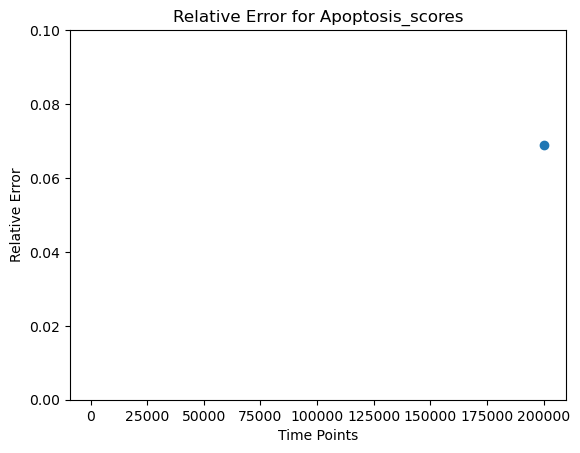

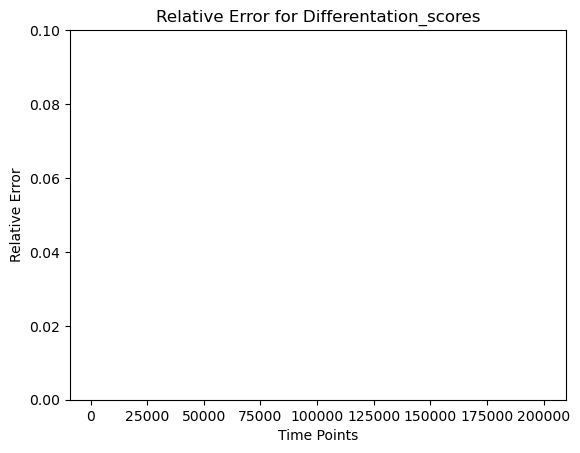

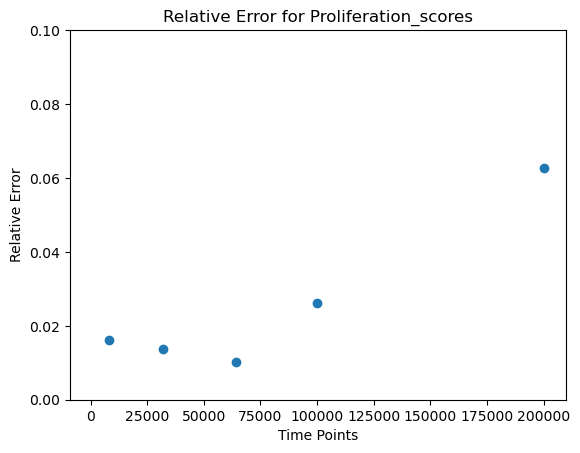

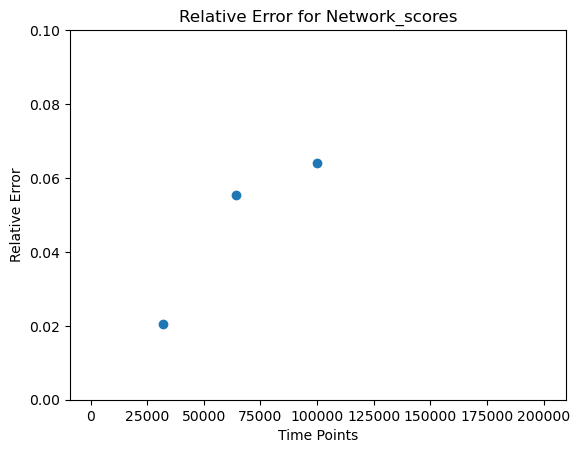

In [9]:
#getting the relative error points to see if the score converges
Apoptosis_scores = scores_dict['Apoptosis']
Differentiation_scores = scores_dict['Differentiation']
Proliferation_scores = scores_dict['Proliferation']
Network_scores = scores_dict['Network']

scores = [Apoptosis_scores, Differentiation_scores, Proliferation_scores, Network_scores]
time_points = [1000, 2000, 4000, 8000, 16000, 32000, 64000, 100000, 200000]

plot_title = {0:'Apoptosis_scores',
              1:'Differentation_scores',
              2: 'Proliferation_scores',
              3: 'Network_scores'}

#print(plot_title)
#print(time_points)

for i in range(len(scores)): #for apop, diff, prolif, or final
    values = [] 
    relative_error = [] #reset the values
    score = scores[i]
    
    title = plot_title[i]
    #print(title)
    
    for i in range(len(time_points)): #for all time points
        point = time_points[i]
        half = (time_points[i])//2
        start_index = slice(0,half) #so for i=1, this is 1:500
        end_index = slice(half,point) #if i=1, this is 500:1000
        
        point = (abs((np.mean(score[start_index])) - (np.mean(score[end_index]))))/(np.mean(score[start_index]))
        
        values.append(point)
    
    relative_error = [np.round(value, decimals=4) for value in values]
    #print(relative_error)  
    
    plot = pd.DataFrame({'time_points': time_points, 'relative_error': relative_error})
    plt.scatter(plot['time_points'], plot['relative_error'])
    plt.xlabel('Time Points')
    plt.ylabel('Relative Error')
    plt.title('Relative Error for ' + title)
    plt.ylim(0, 0.1)
    plt.show()

### Less steps (0.05 noise and 100,000 steps)

In [10]:
%%time

network = bn.BooleanNetwork( ngenes , connectivity_matrix, truth_table, x0  ) # create a Boolean network object
noise_level = 0.05 # noise
network_traj = network.update_noise ( noise_level  , 100000) # simulation with noise

CPU times: total: 3.09 s
Wall time: 3.12 s


In [11]:
%%time

cal_range = network_traj #all of the y values (for relative error plot)
scores_dict, final_score = BMatrix. get_calculating_scores(network_traj, cal_functions, cal_upstream_genes, gene_dict,cal_range)

CPU times: total: 3.28 s
Wall time: 3.28 s


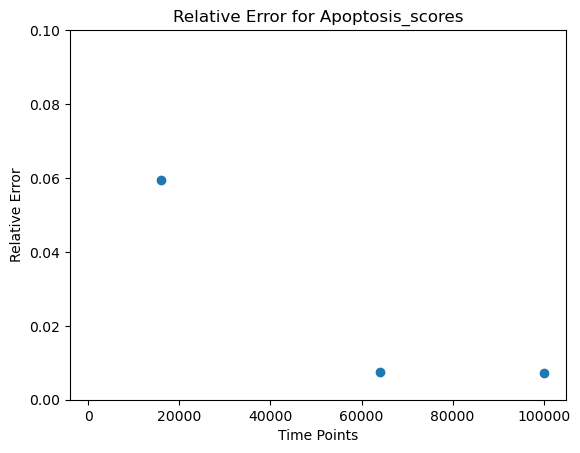

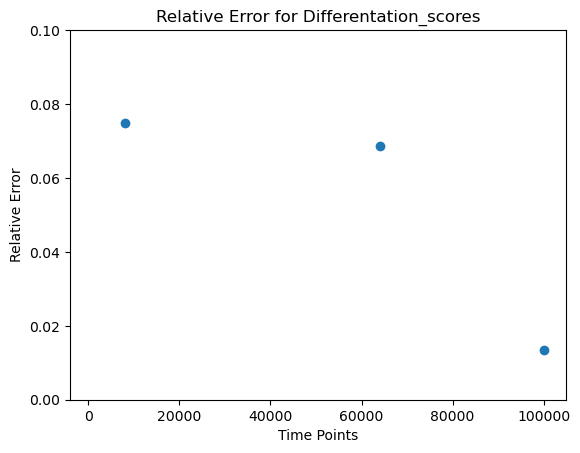

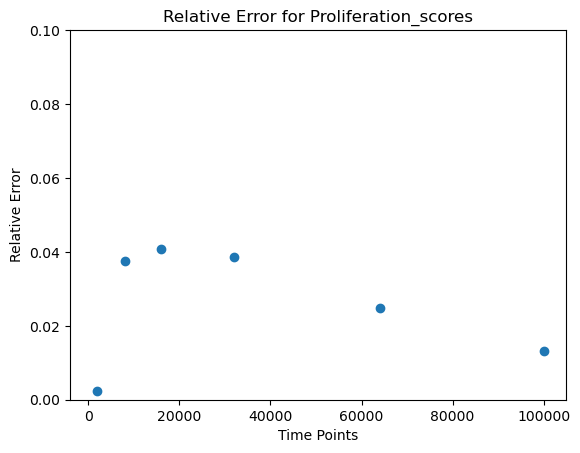

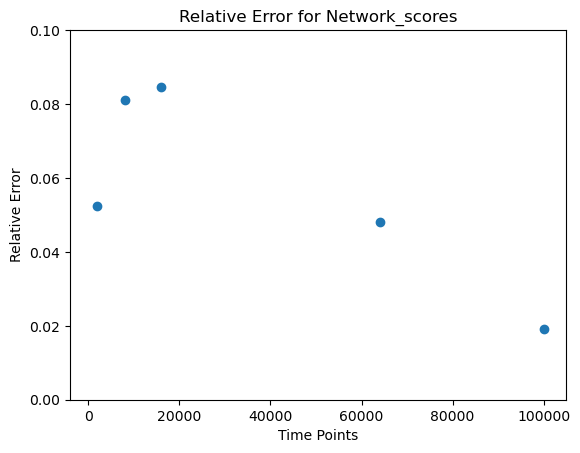

In [12]:
#getting the relative error points to see if the score converges
Apoptosis_scores = scores_dict['Apoptosis']
Differentiation_scores = scores_dict['Differentiation']
Proliferation_scores = scores_dict['Proliferation']
Network_scores = scores_dict['Network']

scores = [Apoptosis_scores, Differentiation_scores, Proliferation_scores, Network_scores]
time_points = [1000, 2000, 4000, 8000, 16000, 32000, 64000, 100000]

plot_title = {0:'Apoptosis_scores',
              1:'Differentation_scores',
              2: 'Proliferation_scores',
              3: 'Network_scores'}

#print(plot_title)
#print(time_points)

for i in range(len(scores)): #for apop, diff, prolif, or final
    values = [] 
    relative_error = [] #reset the values
    score = scores[i]
    
    title = plot_title[i]
    #print(title)
    
    for i in range(len(time_points)): #for all time points
        point = time_points[i]
        half = (time_points[i])//2
        start_index = slice(0,half) #so for i=1, this is 1:500
        end_index = slice(half,point) #if i=1, this is 500:1000
        
        point = (abs((np.mean(score[start_index])) - (np.mean(score[end_index]))))/(np.mean(score[start_index]))
        
        values.append(point)
    
    relative_error = [np.round(value, decimals=4) for value in values]
    #print(relative_error)  
    
    plot = pd.DataFrame({'time_points': time_points, 'relative_error': relative_error})
    plt.scatter(plot['time_points'], plot['relative_error'])
    plt.xlabel('Time Points')
    plt.ylabel('Relative Error')
    plt.title('Relative Error for ' + title)
    plt.ylim(0, 0.1)
    plt.show()

### Less of both (0.01 noise and 100,000 steps)

In [13]:
%%time

network = bn.BooleanNetwork( ngenes , connectivity_matrix, truth_table, x0  ) # create a Boolean network object
noise_level = 0.01 # noise
network_traj = network.update_noise ( noise_level  , 100000) # simulation with noise

CPU times: total: 5.56 s
Wall time: 5.56 s


In [14]:
%%time

cal_range = network_traj #all of the y values (for relative error plot)
scores_dict, final_score = BMatrix. get_calculating_scores(network_traj, cal_functions, cal_upstream_genes, gene_dict,cal_range)

CPU times: total: 3.83 s
Wall time: 3.84 s


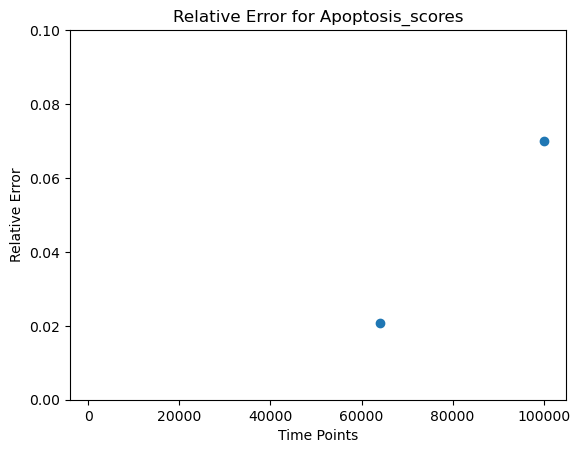

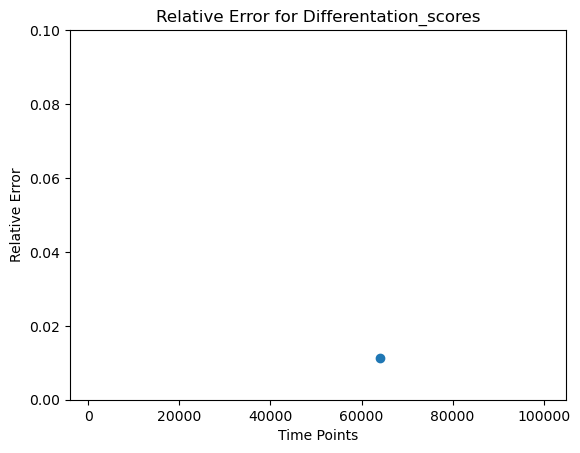

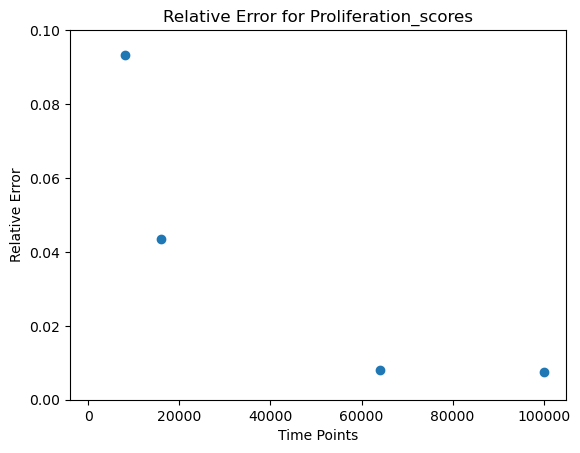

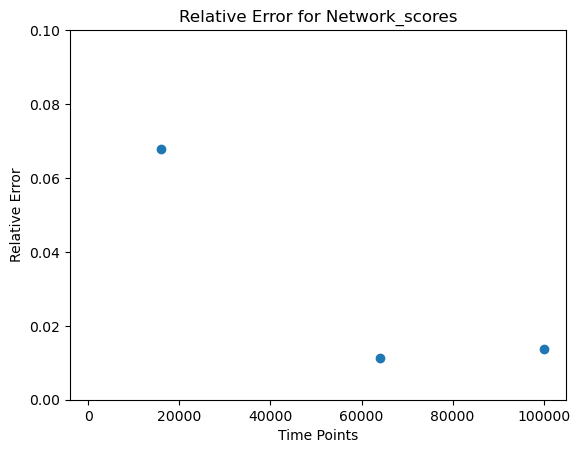

In [15]:
#getting the relative error points to see if the score converges
Apoptosis_scores = scores_dict['Apoptosis']
Differentiation_scores = scores_dict['Differentiation']
Proliferation_scores = scores_dict['Proliferation']
Network_scores = scores_dict['Network']

scores = [Apoptosis_scores, Differentiation_scores, Proliferation_scores, Network_scores]
time_points = [1000, 2000, 4000, 8000, 16000, 32000, 64000, 100000]

plot_title = {0:'Apoptosis_scores',
              1:'Differentation_scores',
              2: 'Proliferation_scores',
              3: 'Network_scores'}

#print(plot_title)
#print(time_points)

for i in range(len(scores)): #for apop, diff, prolif, or final
    values = [] 
    relative_error = [] #reset the values
    score = scores[i]
    
    title = plot_title[i]
    #print(title)
    
    for i in range(len(time_points)): #for all time points
        point = time_points[i]
        half = (time_points[i])//2
        start_index = slice(0,half) #so for i=1, this is 1:500
        end_index = slice(half,point) #if i=1, this is 500:1000
        
        point = (abs((np.mean(score[start_index])) - (np.mean(score[end_index]))))/(np.mean(score[start_index]))
        
        values.append(point)
    
    relative_error = [np.round(value, decimals=4) for value in values]
    #print(relative_error)  
    
    plot = pd.DataFrame({'time_points': time_points, 'relative_error': relative_error})
    plt.scatter(plot['time_points'], plot['relative_error'])
    plt.xlabel('Time Points')
    plt.ylabel('Relative Error')
    plt.title('Relative Error for ' + title)
    plt.ylim(0, 0.1)
    plt.show()